In [1]:
include("./trajopt/utils.jl")
include("./trajopt/dynamics.jl")
include("./funlopt/funl_dynamics.jl")
include("./funlopt/funl_utils.jl")
include("./funlopt/funl_constraint.jl")
include("./trajopt/scaling.jl")
include("./funlopt/funl_synthesis.jl")
# using Plots

run (generic function with 1 method)

In [2]:
# load nominal trajectory
using JLD2, FileIO
filename = "./data/unicycle_N15_traj" 
@load filename my_dict
xnom = my_dict["x"]
unom = my_dict["u"]
tnom = my_dict["t"];
N = size(xnom,2) - 1
dtnom = zeros(N)
for i in 1:N
    dtnom[i] = tnom[i+1]-tnom[i]
end

In [3]:
dynamics = Unicycle()
ix = dynamics.ix
iu = dynamics.iu
decay_rate = 0.1
DLMI = NonlinearDLMI(decay_rate,ix,iu,dynamics.Cv,dynamics.Dvu)
is = DLMI.is

1

In [4]:
function get_H_obs(rx,ry)
    return diagm([1/rx,1/ry])
end
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.5,0.5)
push!(c_list,c1)
push!(H_list,H1)
c2 = [4,3]
H2 = get_H_obs(0.5,0.5)
push!(c_list,c2)
push!(H_list,H2)

vmax = 2.0
vmin = 0.0
wmax = 2.0
wmin = -2.0
list_const = [InputConstraint([1;0],vmax),
    InputConstraint([-1;0],-vmin),
    InputConstraint([0; 1],wmax),
    InputConstraint([0; -1],-wmin),
    ObstacleAvoidance(H_list[1],c_list[1]),
    ObstacleAvoidance(H_list[2],c_list[2])
    ]

6-element Vector{FunnelConstraint}:
 InputConstraint([1, 0], 2.0)
 InputConstraint([-1, 0], -0.0)
 InputConstraint([0, 1], 2.0)
 InputConstraint([0, -1], 2.0)
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [1, 2])
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [4, 3])

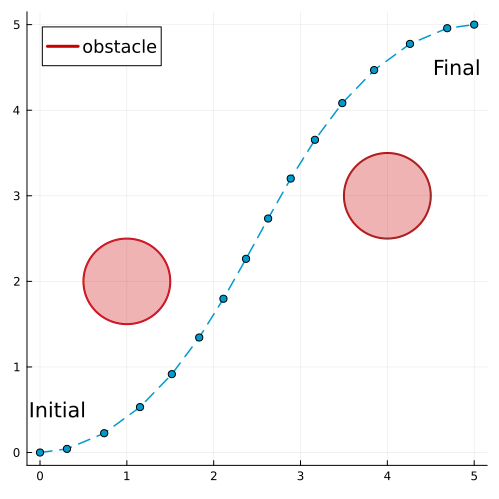

In [5]:
p2 = Plots.plot(; size=(500,500))
plot!(xnom[1,:],xnom[2,:],c=:deepskyblue3,linestyle=:dash,linewidth=1.5,label=nothing)
scatter!(xnom[1,:],xnom[2,:],c=:deepskyblue3,linewidth=1.5,label=nothing)
for (idx,(ce, H)) in enumerate(zip(c_list, H_list))
    label = nothing
    if idx == 1
        label = "obstacle"
    end
    plot_ellipse(p2,inv(H)*inv(H),ce,"red3",label=label)
end
annotate!(0.2, 0.5, text("Initial", :black, :center))
annotate!(4.8, 4.5, text("Final", :black, :center))
display(p2)

In [6]:
@load "./data/unicycle_N15_gamma" my_dict
Lipschitz = my_dict["gamma"]
# Lipschitz = zeros(N+1);

16-element Vector{Float64}:
 0.570571954948126
 0.8308607900113698
 0.844159565287813
 0.8654152957085239
 0.8792184129491256
 0.8687365489650022
 0.5914890127363003
 0.38076391688315914
 0.36437084470729064
 0.43572528000892297
 0.3575909503402617
 0.3402648444649331
 0.38029570329838813
 0.5129076232095225
 0.49656890802460396
 0.21778499063279252

In [7]:
Qnom = zeros(ix,ix,N+1)
Knom = zeros(iu,ix,N+1)
Znom = zeros(ix,ix,N+1);
lamnom = zeros(1,N+1);
nunom = zeros(1,N+1);
Qini = diagm([0.08,0.08,0.06])
Qf = diagm([0.08,0.08,0.06])
for i in 1:N+1
    Qnom[:,:,i] .= Qini
    Znom[:,:,i] .= 1.0I(ix)
end
# Xnom,Unom = QKZS_to_XU(Qnom,Knom,Znom,vcat(lamnom,nunom))
Xnom,Unom = QKZS_to_XU(Qnom,Knom,Znom,lamnom)
;

In [8]:
xmin = [0;0;0];
xmax = [5;5;pi];
umin = [0;0];
umax = [vmax;wmax];
scaler = Scaling(xmin, xmax, umin, umax, tnom[end],0,0)

Scaling([5.0 0.0 0.0; 0.0 5.0 0.0; 0.0 0.0 3.141592653589793], [0.2 0.0 0.0; 0.0 0.2 0.0; 0.0 0.0 0.3183098861837907], [0.0, 0.0, 0.0], [2.0 0.0; 0.0 2.0], [0.5 0.0; 0.0 0.5], [0.0, 0.0], 4.999999999999999, 0.0, 0.0, NaN)

In [9]:
max_iter = 50;
w_funl = 2*1e-2;
w_vc = 1e0;
w_tr::Float64 = 1e0
tol_vc = 1e-6;
tol_tr = 1e-4;
tol_dyn = 1e-1;
verbosity = true;

In [10]:
fs = FunnelSynthesis(N,max_iter,dynamics,DLMI,list_const,scaler,
    w_funl,w_vc,w_tr,tol_tr,tol_vc,tol_dyn,verbosity)

FunnelSynthesis(Unicycle(3, 2, 2, 2, 2, 2, [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [1 0; 0 1; 0 0], [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [0.0, 0.0]), NonlinearDLMI(0.1, 3, 2, 9, 6, 1, 9, 16, [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1]), FunnelConstraint[InputConstraint([1, 0], 2.0), InputConstraint([-1, 0], -0.0), InputConstraint([0, 1], 2.0), InputConstraint([0, -1], 2.0), ObstacleAvoidance([2.0 0.0; 0.0 2.0], [1, 2]), ObstacleAvoidance([2.0 0.0; 0.0 2.0], [4, 3])], Scaling([5.0 0.0 0.0; 0.0 5.0 0.0; 0.0 0.0 3.141592653589793], [0.2 0.0 0.0; 0.0 0.2 0.0; 0.0 0.0 0.3183098861837907], [0.0, 0.0, 0.0], [2.0 0.0; 0.0 2.0], [0.5 0.0; 0.0 0.5], [0.0, 0.0], 4.999999999999999, 0.0, 0.0, NaN), FunnelSolution([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0

In [11]:
run(fs,Xnom,Unom,Lipschitz,Qini,Qf,xnom,unom,dtnom,"Mosek")
# run(fs,Xnom,Unom,Lipschitz,Qini,Qf,xnom,unom,dtnom,"Clarabel")

The elapsed time of discretization is: 6.5390225 seconds
The elapsed time of solver is: 0.057830095291137695 seconds
The elapsed time of subproblem is: 12.695901916 seconds
The elapsed time of multiple shooting is: 1.850138292 seconds
+--------------------------------------------------------------------------------------------------+
|                                   ..:: Penalized Trust Region ::..                               |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
| iter. |    cost    |    tof    |   funl    |   rate    |  param  | log(vc) | log(tr)  | log(dyn) |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
|1      |4.09        |-1.000    |4.823      |-1.000     |-1.000    |-0.4     | 0.5      |2.2e-01   |
The elapsed time of discretization is: 0.27186325 seconds
The elapsed time of solver is: 0.04183506965637207 seconds
The elapsed time of subproblem is: 0.06711

In [12]:
tprop,xprop,uprop = fs.solution.tprop,fs.solution.xprop,fs.solution.uprop
Xprop,Uprop = fs.solution.Xprop,fs.solution.Uprop
Qprop,Kprop,Zprop,Sprop = XU_to_QKZS(Xprop,Uprop,ix,iu)
Qnode,Knode,Znode,Snode = XU_to_QKZS(fs.solution.X,fs.solution.U,ix,iu)

([1.2104438037029717 -0.24970790678570137 0.32472558236786664; -0.24970790678570137 1.1561931715833675 -0.678879449214871; 0.32472558236786664 -0.678879449214871 1.063862252486894;;; 1.1523014052678153 -0.21889199336491014 0.40782539839395504; -0.21889199336491014 1.1033345839948727 -0.6297269541748433; 0.4078253983939551 -0.6297269541748431 0.8216781523449909;;; 1.0957609113008748 -0.11199518319695734 0.473918873276591; -0.11199518319695734 0.933386280706701 -0.5742786237038878; 0.473918873276591 -0.5742786237038878 0.7812162098759823;;; … ;;; 0.17932680866916878 0.06098039350748076 -0.05419288369035767; 0.06098039350748076 0.18905617173326394 -0.2523279989592448; -0.05419288369035766 -0.2523279989592448 0.40943498117176347;;; 0.15593074111259228 0.02409121774122511 -0.032500093653748854; 0.02409121774122511 0.08178059419524875 -0.1173487613136359; -0.032500093653748854 -0.1173487613136359 0.33257125727792;;; 0.08000000320177772 -1.5288849446080473e-9 -7.180949913319856e-9; -1.5288849

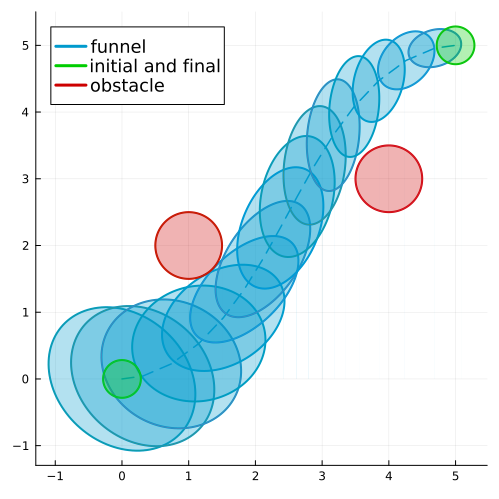

In [13]:
p2 = Plots.plot(; size=(500,500))
plot!(xnom[1,:],xnom[2,:],aspect_ratio=:equal,c=:deepskyblue3,linestyle=:dash,linewidth=1.5,label=nothing)
for idx in 1:N
    label = nothing
    if idx == 1
        label = "funnel"
    end
    plot_ellipse(p2,Qnode[:,:,idx],xnom[:,idx],"deepskyblue3",label=label)
end
plot_ellipse(p2,fs.solution.Qi,xnom[:,1],"green3",label="initial and final")
plot_ellipse(p2,fs.solution.Qf,xnom[:,end],"green3")
for (idx,(ce, H)) in enumerate(zip(c_list, H_list))
    label = nothing
    if idx == 1
        label = "obstacle"
    end
    plot_ellipse(p2,inv(H)*inv(H),ce,"red3",label=label)
end
display(p2)
# savefig("./data_image/funnel_unicycle.pdf")

In [14]:
min_lam_qprop = zeros(size(Qprop,3))
for i in 1:size(Qprop,3)
    eigvals = eigen(Qprop[:,:,i]).values
    min_lam_qprop[i] = eigvals[1]
end
min_lam_q = zeros(size(Qnode,3))
for i in 1:size(Qnode,3)
    eigvals = eigen(Qnode[:,:,i]).values
    min_lam_q[i] = eigvals[1]
end

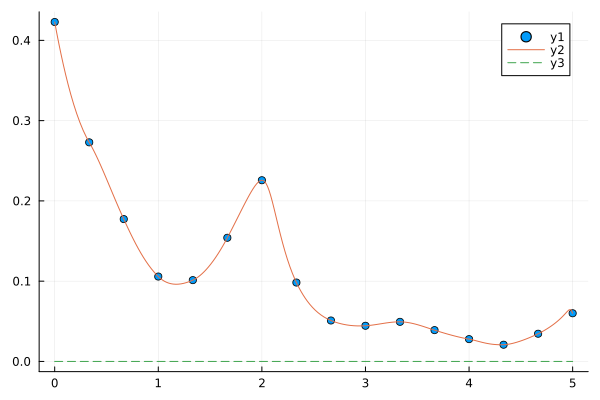

In [15]:
scatter(tnom,min_lam_q,seriestype="o")
plot!(tprop,min_lam_qprop)
plot!(tnom,tnom .* 0,linestyle=:dash)

In [16]:
findfirst(x -> x < 0, min_lam_q)

# input funnel

In [17]:
function project_onto_input(Q,K) 
    R = []
    for i in 1:size(Q,3)
        K_ = K[:,:,i]
        push!(R,K_*Q[:,:,i]*K_')
    end
    projected_input_funl = []
    for j in 1:iu
        a = zeros(iu)
        a[j] = 1
        each_funl = []
        for i in 1:length(R)
            push!(each_funl,sqrt(a'*R[i]*a))
        end
        push!(projected_input_funl,each_funl)
    end
    return projected_input_funl
end

project_onto_input (generic function with 1 method)

In [18]:
input_proj_funl_nom = project_onto_input(Qnode,Knode)
input_proj_funl_prop = project_onto_input(Qprop,Kprop)

2-element Vector{Any}:
 Any[0.5738357990732235, 0.5757542113535324, 0.5790356594213673, 0.5829285948488042, 0.5878148277362639, 0.5934657495176086, 0.5999974505856607, 0.6073051733868786, 0.6154047939035067, 0.6242410155883328  …  0.6351130952308016, 0.628995375201058, 0.6218000700019949, 0.6150753116430905, 0.6082589163911356, 0.6015301321205325, 0.5947920536631395, 0.5881000543748377, 0.5814384534322624, 0.5748716766966365]
 Any[1.4048628767743412, 1.394350129279269, 1.3768933680623758, 1.357009227055196, 1.3332549589165454, 1.3073555163330504, 1.2793808176280257, 1.2503951217359015, 1.2209010509387677, 1.191625476287547  …  1.2472810049669751, 1.2618478733875214, 1.2787484764135084, 1.2951647848651395, 1.313015687487358, 1.33217710814041, 1.3530588648380988, 1.3754987698839134, 1.3994465275965158, 1.4244902130264294]

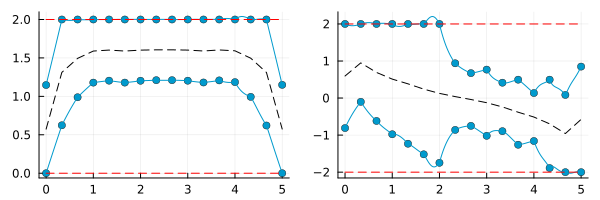

In [19]:
p1 = plot(tnom,unom[1,:],linestyle=:dash,color="black",label="")
scatter!(tnom,unom[1,:]+input_proj_funl_nom[1],color="deepskyblue3",label="")
scatter!(tnom,unom[1,:]-input_proj_funl_nom[1],color="deepskyblue3",label="")
plot!(tprop,uprop[1,:]+input_proj_funl_prop[1],color="deepskyblue3",label="")
plot!(tprop,uprop[1,:]-input_proj_funl_prop[1],color="deepskyblue3",label="")
plot!(tnom,tnom*0 .+ vmax,linestyle=:dash,color="red",label="")
plot!(tnom,tnom*0 .+ vmin,linestyle=:dash,color="red",label="")
p2 = plot(tnom,unom[2,:],linestyle=:dash,color="black",label="")
scatter!(tnom,unom[2,:]+input_proj_funl_nom[2],color="deepskyblue3",label="")
scatter!(tnom,unom[2,:]-input_proj_funl_nom[2],color="deepskyblue3",label="")
plot!(tprop,uprop[2,:]+input_proj_funl_prop[2],color="deepskyblue3",label="")
plot!(tprop,uprop[2,:]-input_proj_funl_prop[2],color="deepskyblue3",label="")
plot!(tnom,tnom*0 .+ wmax,linestyle=:dash,color="red",label="")
plot!(tnom,tnom*0 .+ wmin,linestyle=:dash,color="red",label="")
plot(p1,p2,layout=(1,2),size=(600,200))

In [ ]:
using Random
using LinearAlgebra

In [ ]:
include("./funlopt/funl_utils.jl")

In [ ]:
xs_list = []
for i in 1:50
    z = randn(ix)
    z = z / norm(z)
    push!(xs_list,xnom[:,1] + sqrt(Qnode[:,:,1]) * z)
end

In [ ]:
xsam_fwd,tsam,xsam,usam = [],[],[],[]
xnom_sam = []
for xs in xs_list
    xf_,ts_,xsam_,usam_,_ = propagate_from_funnel_entry(xs,DLMI,dynamics,xnom,unom,dtnom,Knode)
    push!(xsam_fwd,xf_)
    push!(tsam,ts_)
    push!(xsam,xsam_)
    push!(usam,usam_)
    # push!(xnom_sam,xnom_)
end

In [ ]:
p2 = Plots.plot(; size=(500,500))
plot!(xnom[1,:],xnom[2,:],c=:deepskyblue3,linestyle=:dash,linewidth=1.5,label=nothing)
for idx in 1:N
    label = nothing
    if idx == 1
        label = "funnel"
    end
    plot_ellipse(p2,Qnode[:,:,idx],xnom[:,idx],"deepskyblue3",label=label)
end
plot_ellipse(p2,fs.solution.Qi,xnom[:,1],"green3",label="initial and final")
plot_ellipse(p2,fs.solution.Qf,xnom[:,end],"green3")
for (idx,(ce, H)) in enumerate(zip(c_list, H_list))
    label = nothing
    if idx == 1
        label = "obstacle"
    end
    plot_ellipse(p2,inv(H)*inv(H),ce,"red3",label=label)
end
for x_ in xsam
    plot!(x_[1,:],x_[2,:],color="purple",label=nothing)
end
display(p2)

# Lipschitz constant estimation

In [ ]:
# input funnel
Rnode = []
for i in 1:size(Qnode,3)
    K_ = Knode[:,:,i]
    push!(Rnode,K_*Qnode[:,:,i]*K_')
end

In [ ]:
gamma_est = Lipschitz_estimation_around_traj(N,100,xnom,unom,dynamics,Qnode,Rnode)

In [ ]:
# using JLD2, FileIO
# my_dict = Dict("gamma" => gamma_est)
# @save "./data/unicycle_N15_gamma" my_dict